In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
from tqdm import tqdm

d:\Resume_Project\Lungs_XRay_Classification\lungs\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import os
os.chdir("artifacts/06_16_2024_15_50_13/data_ingestion/data")

In [10]:
data_path = os.getcwd()

## Exploring the data or images

In [11]:
# Defining the class name 
class_name = ['NORMAL','PNEUMONIA']

In [12]:
# Creating a function to get the list of files
def get_list_of_files(dir_name):
    '''
        input = The input directory loaction
        output = Returns the list of files in the directory
    '''
    files_list = os.listdir(dir_name)       #listdir() returns a list of all files and directories in the current directory
    return files_list

In [14]:
# Accessing the different classes in the data folder

data_path+'/train/'+class_name[0]

'D:\\Resume_Project\\Lungs_XRay_Classification\\artifacts\\06_16_2024_15_50_13\\data_ingestion\\data/train/NORMAL'

In [18]:
# Acessing the train folders and all the images from that

files_list_normal_train = get_list_of_files(data_path+'/train/'+class_name[0])
files_list_pneumonia_train = get_list_of_files(data_path+'/train/'+class_name[1])

In [19]:
# Acessing the train folders and all the images from that

files_list_normal_test = get_list_of_files(data_path+'/test/'+class_name[0])
files_list_pneumonia_test = get_list_of_files(data_path+'/test/'+class_name[1])

In [20]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of test samples in Ppneumonia category {}".format(len(files_list_pneumonia_train)))
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneumonia_test)))

Number of train samples in Normal category 105
Number of test samples in Ppneumonia category 105
Number of train samples in Normal category 105
Number of test samples in Pneumonia category 30


(1041, 1616)


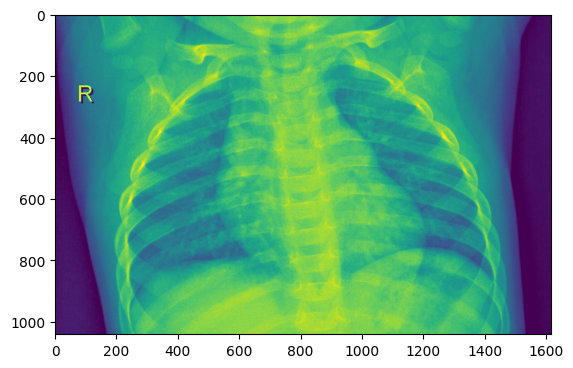

In [21]:
# Selecting any random normal image and printing it
rand_img_no = np.random.randint(0, len(files_list_normal_train))
img = data_path + '/train/NORMAL/' + files_list_normal_train[rand_img_no]
print(plt.imread(img).shape)

img = mpimg.imread(img)
implot = plt.imshow(img)
plt.show()

(968, 1304)


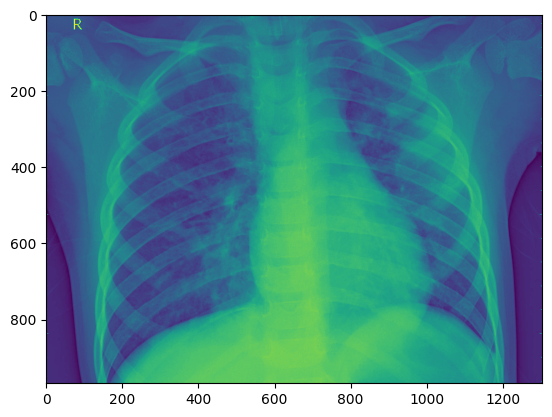

In [25]:
# Selecting any random pneumonia image and printing it

rand_no = np.random.randint(0,len(files_list_pneumonia_train))
img = data_path + '/train/PNEUMONIA/'+ files_list_pneumonia_train[rand_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()


(1384, 2022)


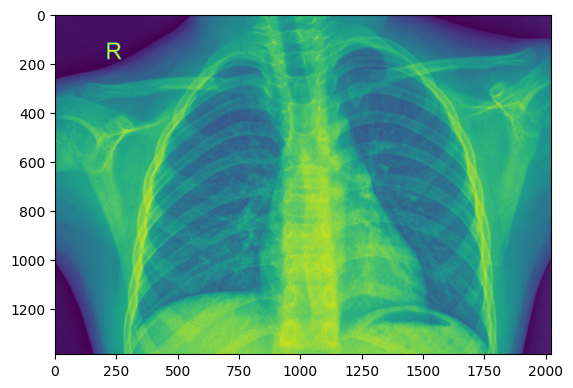

In [26]:

rand_img_no = np.random.randint(0,len(files_list_normal_test))
img = data_path + '/test/NORMAL/'+ files_list_normal_test[rand_img_no]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(654, 1136)


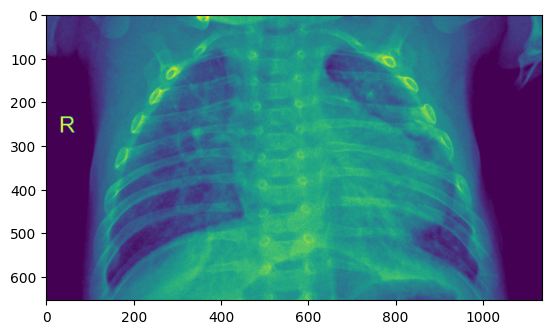

In [27]:

img = data_path + '/test/PNEUMONIA/'+ files_list_pneumonia_test[np.random.randint(0,len(files_list_pneumonia_test))]
print(plt.imread(img).shape)
img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

## Transforming the Images

Now that we have seen a sample of the images, let's transform the data.

We need to perform transformations on both train and test images. For training data, we also need to perform data augmentation.

**Data Augmentation** is done to create synthetic data.

In transformation, we are doing:
- **Resize**: Resize the input image to the given size.
- **CenterCrop**: Crops the given image at the center.
- **ColorJitter**: Randomly change the brightness, contrast, saturation, and hue of an image.
- **RandomHorizontalFlip**: Horizontally flip the given image randomly with a given probability.
- **RandomRotation**: Rotate the image by angle.
- **ToTensor**: Convert numpy.ndarray to tensor.
- **Normalize**: Normalize a float tensor image with mean and standard deviation.


In [28]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])


In [29]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

## Creating Data Loader

For our use case, we will be using the default data loader for PyTorch.

We will be creating two data loaders: one for the training data and another for the test data.

**Batch size** is a hyperparameter which we can tweak according to our need and system configuration.

We can set image shuffling to **True** for training data and **False** for test data.

**Pin memory** is used to transfer the loaded dataset from CPU to GPU.


ImageFolder class: Responsible for loading images from train and val folders into a PyTorch dataset

In [31]:
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'),
                                  transform = train_transform)

train_data

Dataset ImageFolder
    Number of datapoints: 210
    Root location: D:\Resume_Project\Lungs_XRay_Classification\artifacts\06_16_2024_15_50_13\data_ingestion\data\train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=[-0.1, 0.1])
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [32]:
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'),
                                  transform = test_transform)

test_data

Dataset ImageFolder
    Number of datapoints: 60
    Root location: D:\Resume_Project\Lungs_XRay_Classification\artifacts\06_16_2024_15_50_13\data_ingestion\data\test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Data loader combines a dataset and a sampler, and provides an iterable over the given dataset

In [33]:
train_loader = DataLoader(train_data,
                          batch_size=2,
                          shuffle=False,
                          pin_memory=True)

In [34]:
test_loader = DataLoader(test_data,
                          batch_size=2,
                          shuffle=False,
                          pin_memory=True)

## Creating the Model Architecture

- **First Layer**: The input layer consists of 3 input channels. The output channels have a kernel size of 3x3, padding=0, and bias=True. The activation function used is ReLU, and batch normalization is performed.
- **Max Pooling**: This is performed to extract the important features from the image.
- **Convolutional Layers**: The model is passed through 9 convolutional layers.
- **Output Layer**: Finally, the model is passed through an output layer which provides binary classification.


In [35]:
class Net(nn.Module):
    def __init__(self):
        """
        Creating custom CNN architecture for Image classification
        """
        super(Net, self).__init__()
        # Input Block
        self.convolution_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3),
                    padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        self.pooling11 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 1
        self.convolution_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=20, kernel_size=(3, 3),
                    padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.pooling22 = nn.MaxPool2d(2, 2)
        self.convolution_block3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10),
        )
        self.pooling33 = nn.MaxPool2d(2, 2)
        # CONVOLUTION BLOCK 2
        self.convolution_block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(20)
        )
        self.convolution_block5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(10),
#         )
        self.convolution_block6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding='same', bias=True),
#             nn.ReLU(),
#             nn.BatchNorm2d(32)
#         )
        self.convolution_block7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(10)
        )
        self.convolution_block8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(14)
        )
        self.convolution_block9 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=True),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        )
        self.convolution_block_out = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=True),
        )
    def forward(self, x):
        x = self.convolution_block1(x)
        x = self.pooling11(x)
        x = self.convolution_block2(x)
        x = self.pooling22(x)
        x = self.convolution_block3(x)
        x = self.pooling33(x)
        x = self.convolution_block4(x)
        x = self.convolution_block5(x)
#         x = self.convblock6(x)
        x = self.convolution_block6(x)
#         x = self.convblock8(x)
        x = self.convolution_block7(x)
        x = self.convolution_block8(x)
        x = self.convolution_block9(x)
        x = self.gap(x)
        x = self.convolution_block_out(x)
        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [36]:
# To check weather cuda is available in the system or not 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

Available processor cpu


In [38]:
model = Net().to(device)

# To check the model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
       BatchNorm2d-3          [-1, 8, 222, 222]              16
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5         [-1, 20, 109, 109]           1,460
              ReLU-6         [-1, 20, 109, 109]               0
       BatchNorm2d-7         [-1, 20, 109, 109]              40
         MaxPool2d-8           [-1, 20, 54, 54]               0
            Conv2d-9           [-1, 10, 54, 54]             210
             ReLU-10           [-1, 10, 54, 54]               0
      BatchNorm2d-11           [-1, 10, 54, 54]              20
        MaxPool2d-12           [-1, 10, 27, 27]               0
           Conv2d-13           [-1, 20, 25, 25]           1,820
             ReLU-14           [-1, 20,

In [39]:
train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch):
    """
    Description: To train the model 
    
    input: model,device,train_loader,optimizer,epoch 
    
    output: loss, batch id and accuracy
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)
        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN
        # or specific requirements
        ## prediction on data
        y_pred = model(data)
        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)
        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


In [40]:
test_losses = []
test_acc = []

def test(model, device, test_loader):
    """
    Description: To test the model
    
    input: model, device, test_loader
    
    output: average loss and accuracy
    
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))


In [41]:
# Defining the params for training 
model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)
EPOCHS = 1

In [44]:

#Training the model
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('current Learning Rate: ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=3.6596287827705964e-05 Batch_id=104 Accuracy=93.81: 100%|██████████| 105/105 [00:11<00:00,  9.28it/s]


current Learning Rate:  0.01

Test set: Average loss: 3.9643, Accuracy: 29/60 (48.33%)



Text(0.5, 1.0, 'Test Accuracy')

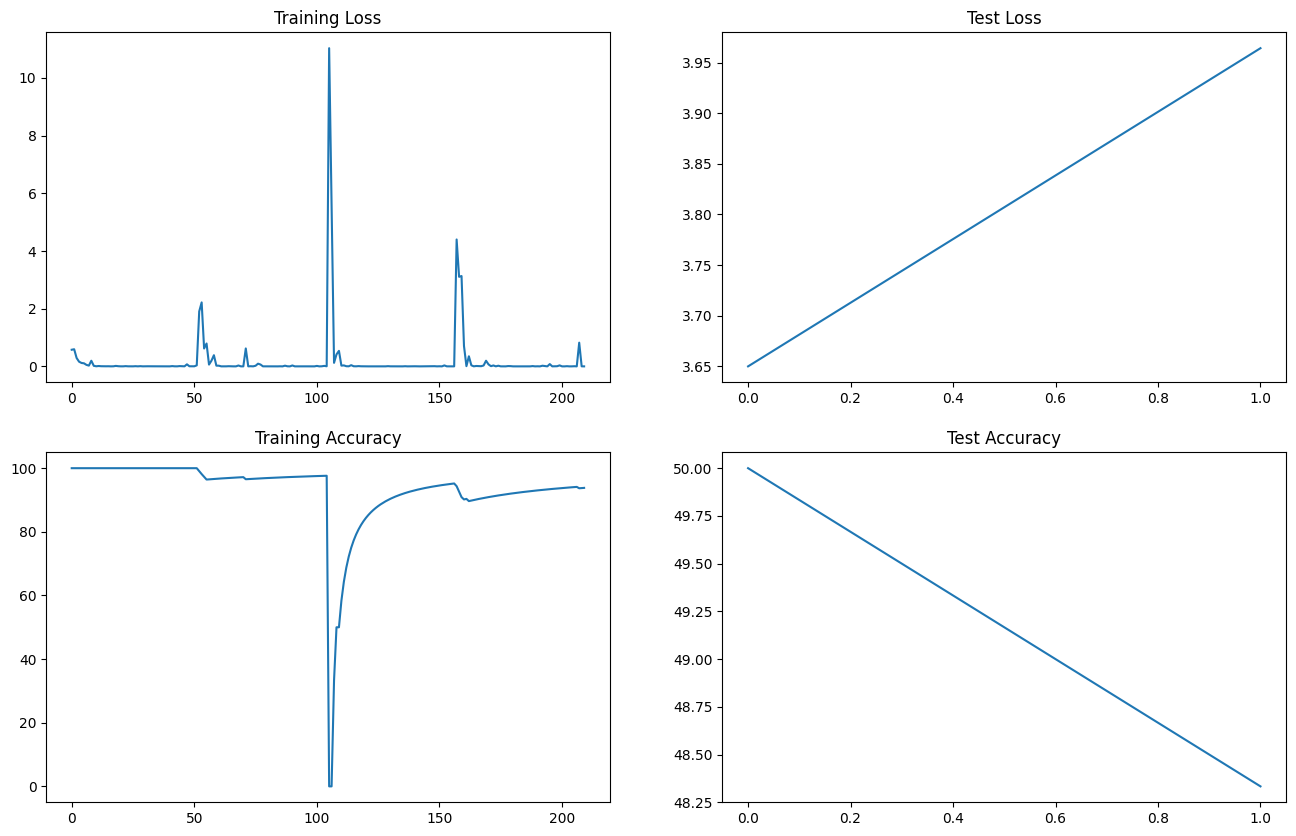

In [45]:
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_acc]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_acc]
fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")